# **Descrição do Notebook**

Neste notebook está descrito a implementação de um classificador linear com a função de ativação softmax e também a implementação de uma Rede Neural com 2 features de entrada. Como se pode notar um classificador linear possui 50,33% de acurácia, enquanto a Rede Neural traz 99% de acurácia na classificação de uma entrada.

# **Bibliotecas**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# **Criando um conjunto de dados para análise**

Aqui escolhemos uma variação de 3 valores distribuidos em espiral. Esses valores são linearmente não separáveis

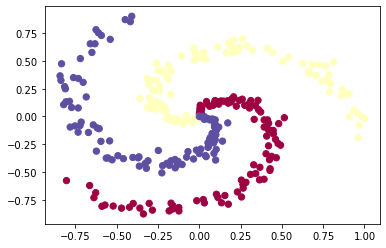

In [2]:
# variáveis de formação
N = 100 # número de pontos por classe
D = 2 # dimensionalidade do problema
K = 3 # número de classes

# iniciando o conjunto de dados como nulo
X = np.zeros((N*K,D)) # matriz de dados (cada coluna = 1 exemplar)
y = np.zeros(N*K, dtype='uint8') # classes 

# preenchendo os valores dos conjuntos de dados
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # raio
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

# visualizando a distribuição de dados
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

# **Treinando um classificador linear com softmax**

### Entendendo as etapas do classificador linear

O classificador Softmax tem uma função de pontuação linear e usa a perda de entropia cruzada (CrossEntropyLoss). Os parâmetros do classificador linear consistem em uma matriz de pesos **W** e um vetor de tendência **b** para cada classe. Vamos primeiro inicializar esses parâmetros para serem números aleatórios:

In [3]:
# inicializando os pesos de forma aleatória e não nula 
W = 0.01 * np.random.randn(D,K) 
b = np.zeros((1,K))  #b pode iniciar de forma nula
print(W.shape)
print(b.shape)

(2, 3)
(1, 3)


In [4]:
# calculando a função pontuação das classes scores = a 
scores = np.dot(X,W) + b  # aqui temos 300 pontos que são 2D 
scores.shape

(300, 3)

#### Computando a função de perda

O segundo ingrediente-chave de que precisamos é uma função de perda, que é um objetivo diferenciável que quantifica nossa infelicidade com as pontuações computadas da turma. Intuitivamente, queremos que a classe correta tenha uma pontuação maior do que as outras classes. Quando este for o caso, a perda deve ser baixa e, caso contrário, a perda deve ser alta. Existem muitas maneiras de quantificar essa intuição, mas neste exemplo vamos usar a perda de entropia cruzada associada ao classificador Softmax. Lembre-se que sef
é a matriz de pontuações de classe para um único exemplo (por exemplo, matriz de 3 números aqui), então o classificador Softmax calcula a perda para esse exemplo como:

$$
L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right)
$$

Podemos ver que o classificador Softmax interpreta todos os elementos def
como mantendo as probabilidades logarítmicas (não normalizadas) das três classes. Nós os exponenciamos para obter probabilidades (não normalizadas) e, em seguida, normalizamos para obter probabilidades. Portanto, a expressão dentro do log é a probabilidade normalizada da classe correta. Observe como funciona esta expressão: esta quantidade está sempre entre 0 e 1. Quando a probabilidade da classe correta é muito pequena (próxima de 0), a perda irá para o infinito (positivo). Por outro lado, quando a probabilidade de classe correta for para 1, a perda irá para zero porquel o g(1)=0
. Assim, a expressão paraeueu
é baixo quando a probabilidade de classe correta é alta e é muito alto quando é baixo.

Lembre-se também de que a perda total do classificador Softmax é então definida como a perda média de entropia cruzada sobre os exemplos de treinamento e a regularização:

$$
L =  \underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \frac{1}{2} \lambda \sum_k\sum_l W_{k,l}^2 }_\text{regularization loss} \\\\
$$
Dada a matriz de `scores` que calculamos acima, podemos calcular a perda. Primeiro, a maneira de obter as probabilidades é direta:

In [5]:
## Computando a função custo

# pegando tamanho de exemplo do dataset 
num_examples = X.shape[0] 

# gerando a função exponencial, que traz as probabilidades não normalizadas
exp_scores = np.exp(scores) 

# normalizando as propabilidades 
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

Agora temos um array `probs`de tamanho [300 x 3], onde cada linha agora contém as probabilidades da classe. Em particular, uma vez que os normalizamos, cada linha agora soma um. Agora podemos consultar as probabilidades de log atribuídas às classes corretas em cada exemplo:

In [6]:
correct_logprobs = -np.log(probs[range(num_examples),y])

In [7]:
# compute the loss: average cross-entropy loss and regularization
reg = 1e-3
data_loss = np.sum(correct_logprobs)/num_examples
reg_loss = 0.5*reg*np.sum(W*W)
loss = data_loss + reg_loss

#### Calculando o gradiente analítico com retropropagação

Temos uma forma de avaliar a perda, e agora temos que minimizá-la. Faremos isso com gradiente descendente. Ou seja, começamos com parâmetros aleatórios (como mostrado acima) e avaliamos o gradiente da função de perda em relação aos parâmetros, para sabermos como devemos alterar os parâmetros para diminuir a perda. Vamos introduzir a variável intermediária $p$
, que é um vetor das probabilidades (normalizadas). A perda para um exemplo é:

$$
p_k = \frac{e^{f_k}}{ \sum_j e^{f_j} } \hspace{1in} L_i =-\log\left(p_{y_i}\right)
$$

Agora queremos entender como as pontuações computadas dentrof
deve mudar para diminuir a perda $L_i$ que este exemplo contribui para o objetivo completo. Em outras palavras, queremos derivar o gradiente $ \partial L_i / \partial f_k $. A perda $L_i$ é calculado a partir $p$, que por sua vez depende de  $f$. É um exercício divertido para o leitor usar a regra da cadeia para derivar o gradiente, mas acaba sendo extremamente simples e interpretável no final, depois que muitas coisas se anulam:

$$
\frac{\partial L_i }{ \partial f_k } = p_k - \mathbb{1}(y_i = k)
$$

Observe como essa expressão é elegante e simples. Suponha que as probabilidades que calculamos fossem `p = [0.2, 0.3, 0.5]`, e que a classe correta fosse a do meio (com probabilidade 0,3). De acordo com esta derivação, o gradiente nas pontuações seria `df = [0.2, -0.7, 0.5]`. Lembrando qual é a interpretação do gradiente, vemos que esse resultado é altamente intuitivo: aumentar o primeiro ou o último elemento do vetor fde escores (os escores das classes incorretas) leva a um aumento da perda (devido aos sinais positivos +0,2 e + 0,5) - e aumentar a perda é ruim, como esperado. No entanto, aumentar a pontuação da classe correta tem influência negativa na perda. O gradiente de -0,7 está nos dizendo que aumentar a pontuação correta da classe levaria a uma diminuição da perda $L_i$ , o que faz sentido.

Tudo isso se resume ao seguinte código. Lembre-se de que `probs`armazena as probabilidades de todas as classes (como linhas) para cada exemplo. Para obter o gradiente nas pontuações, que chamamos `dscores`de , procedemos da seguinte forma:


In [8]:
# calculando o gradiente analitico com a backpropagation
dscores = probs
dscores[range(num_examples),y] -= 1
dscores /= num_examples

Agora de posso dos valores score e com o seu gradiente, conseguimos vamos retropopagar para os valores de W e b.

Onde vemos que retrocedemos através da operação de multiplicação de matrizes e também adicionamos a contribuição da regularização. Observe que o gradiente de regularização tem uma forma muito simples, `reg*W` pois usamos a constante 0.5 para sua contribuição de perda. Este é um truque de conveniência comum que simplifica a expressão de gradiente.

In [9]:
dW = np.dot(X.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)
dW += reg*W # nao esqueça de regulariz o gradiente

In [10]:
# atualizando os parametros w e b ( w = w -step_size*dW)
step_size = 1e-0
W += -step_size * dW
b += -step_size * db

### Classificador Linear Pronto

In [11]:
#Treinando um classificador Linear

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(200):

  # evaluate class scores, [N x K]
  scores = np.dot(X, W) + b

  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W)
  loss = data_loss + reg_loss
  if i % 10 == 0:
    print("iteration %d: loss %f" % (i, loss))

  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples

  # backpropate the gradient to the parameters (W,b)
  dW = np.dot(X.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)

  dW += reg*W # regularization gradient

  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db

iteration 0: loss 1.098412
iteration 10: loss 0.905250
iteration 20: loss 0.833031
iteration 30: loss 0.799929
iteration 40: loss 0.782552
iteration 50: loss 0.772588
iteration 60: loss 0.766518
iteration 70: loss 0.762660
iteration 80: loss 0.760128
iteration 90: loss 0.758425
iteration 100: loss 0.757259
iteration 110: loss 0.756448
iteration 120: loss 0.755877
iteration 130: loss 0.755471
iteration 140: loss 0.755181
iteration 150: loss 0.754971
iteration 160: loss 0.754819
iteration 170: loss 0.754708
iteration 180: loss 0.754627
iteration 190: loss 0.754568


### Avaliando o modelo

In [12]:
# avaliando a acuracia do modelo
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print('Acurácia do modelo: {:.2f}%'.format((np.mean(predicted_class == y)*100)))

Acurácia do modelo: 50.33%


### Imprimindo o classificador linear

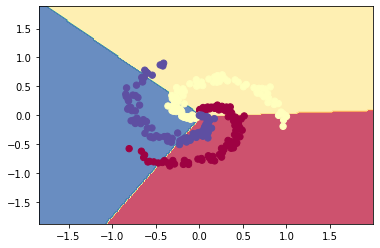

In [13]:
# imprimindo o classificador
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

# **Treinando uma Rede Neural**

### Entendendo as etapas da Rede Neural

Claramente, um classificador linear é inadequado para este conjunto de dados e gostaríamos de usar uma Rede Neural. Uma camada oculta adicional será suficiente para esses dados de brinquedo. Agora vamos precisar de dois conjuntos de pesos e bias (para a primeira e segunda camadas):

In [14]:
# inicializando os parametros randomicamente
h = 100 # tamanho da camada escondida
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

Agora a propagação muda de forma pois temos uma camada escondida, então temos que 

In [15]:
# evaluate class scores with a 2-layer Neural Network
hidden_layer = np.maximum(0, np.dot(X, W) + b) # ativação ReLU
scores = np.dot(hidden_layer, W2) + b2  #pontuação na cama de saída

Observe que a única alteração anterior é uma linha extra de código, onde primeiro calculamos a representação da camada oculta e, em seguida, as pontuações com base nessa camada oculta. Crucialmente, também adicionamos uma não linearidade, que neste caso é ReLU simples que limita as ativações na camada oculta em zero.

Tudo o resto permanece o mesmo. Calculamos a perda com base nas pontuações exatamente como antes e obtemos o gradiente para as pontuações `dscores`exatamente como antes. No entanto, a forma como retropropagamos esse gradiente nos parâmetros do modelo agora muda de forma, é claro. Primeiro vamos retropropagar a segunda camada da Rede Neural. Isso parece idêntico ao código que tínhamos para o classificador Softmax, exceto que estamos substituindo X(os dados brutos) pela variável `hidden_layer`):

In [16]:
# backpropate the gradient to the parameters

num_examples = X.shape[0]
exp_scores = np.exp(scores)
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

# compute the loss: average cross-entropy loss and regularization
correct_logprobs = -np.log(probs[range(num_examples),y])
data_loss = np.sum(correct_logprobs)/num_examples
reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
loss = data_loss + reg_loss

# calculando o gradiente analitico com a backpropagation
dscores = probs
dscores[range(num_examples),y] -= 1
dscores /= num_examples


dW2 = np.dot(hidden_layer.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)

No entanto, ao contrário de antes, ainda não terminamos, porque `hidden_layer`é em si uma função de outros parâmetros e dados! Precisamos continuar a retropropagação por meio dessa variável. Seu gradiente pode ser calculado como:

In [17]:
dhidden = np.dot(dscores, W2.T)

Agora temos o gradiente nas saídas da camada oculta. Em seguida, temos que retropropagar a não linearidade ReLU. Isso acaba sendo fácil porque ReLU durante a passagem para trás é efetivamente uma chave. Desde a $r = max(0, x)$, temos isso $\frac{dr}{dx} = 1(x > 0) $. Combinado com a regra da cadeia, vemos que a unidade ReLU permite que o gradiente passe inalterado se sua entrada for maior que 0, mas o mata se sua entrada for menor que zero durante a passagem para frente. Portanto, podemos retropropagar o ReLU no local simplesmente com:

In [18]:
# backprop the ReLU non-linearity
dhidden[hidden_layer <= 0] = 0

In [19]:
# finalmente temos os gradientes referentes a  W,b
dW = np.dot(X.T, dhidden)
db = np.sum(dhidden, axis=0, keepdims=True)

In [20]:
# adicionando a contribuição ao gradiente
dW2 += reg * W2
dW += reg * W

# atualizando os parametros
W += -step_size * dW
b += -step_size * db
W2 += -step_size * dW2
b2 += -step_size * db2

### Rede Neural pronta

In [21]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):

  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2

  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  if i % 1000 == 0:
    print("iteration %d: loss %f" % (i, loss))

  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples

  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)

  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W

  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2

iteration 0: loss 1.098567
iteration 1000: loss 0.293042
iteration 2000: loss 0.272492
iteration 3000: loss 0.267080
iteration 4000: loss 0.261597
iteration 5000: loss 0.254842
iteration 6000: loss 0.248813
iteration 7000: loss 0.246383
iteration 8000: loss 0.245008
iteration 9000: loss 0.244070


### Avaliando o modelo

In [22]:
# avaliando a acurácia do modelo
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print('acurácia do modelo: {:.2f}%'.format((np.mean(predicted_class == y))))

acurácia do modelo: 0.99%


### Gráfico da classificação

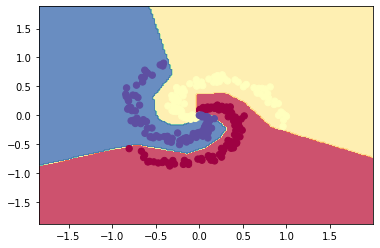

In [23]:
# imprimindo o resultado
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

# **Conclusão**

Trabalhamos com um conjunto de dados 2D de brinquedo e treinamos uma rede linear e uma rede neural de 2 camadas. Vimos que a mudança de um classificador linear para uma Rede Neural envolve muito poucas mudanças no código. A função score muda de forma (diferença de 1 linha de código), e a backpropagation muda de forma (temos que realizar mais uma rodada de backprop através da camada oculta para a primeira camada da rede).